# Overview
This is a simple end to end example of how you can use SAS Viya for analysis
The example follows these steps:
1. Importing the needed Python packages
1. Starting a CAS session on an already running CAS server
1. Checking the server status
1. Loading data from the local file system to the CAS server
1. Explore the data
1. Impute missing values
1. Partition the data into training and validation partitions
1. Build a decision tree
1. Build a neural network
1. Build a decision forest
1. Build a gradient boost
1. Assess the models
1. Build ROC charts

## Setup and initialize

Find doc for all the CAS actions [here](http://casjml01.unx.sas.com:8080/job/Actions_ref_doc_vb005/ws/casaref/index.html) 

In this code we import the needed packages and we assign variables for the modeling details that will be used later in the analysis

In [1]:
from swat import *
from swat.render import render_html
from pprint import pprint
from matplotlib import pyplot as plt
import pandas as pd
import sys
%matplotlib inline

target          = "bad"
class_inputs    = ["reason", "job"]
class_vars      = [target] + class_inputs
interval_inputs = ["im_clage", "clno", "im_debtinc", "loan", "mortdue", "value", "im_yoj", "im_ninq", "derog", "im_delinq"]
all_inputs      = interval_inputs + class_inputs

indata_dir = '/home/sasdemo/data'
indata = 'hmeq'

## Start CAS session

In this code we assign values for the cashost, casport, and casauth values. These are then used to establish a CAS session named `sess`.

In [2]:
cashost='localhost'
casport=5570
casauth='~/.authinfo'
sess = CAS(cashost, casport, authinfo=casauth, caslib="casuser")

# Load the needed action sets for this example:
sess.loadactionset(actionset="dataStep")
sess.loadactionset(actionset="dataPreprocess")
sess.loadactionset(actionset="cardinality")
sess.loadactionset(actionset="sampling")
sess.loadactionset(actionset="regression")
sess.loadactionset(actionset="decisionTree")
sess.loadactionset(actionset="neuralNet")
sess.loadactionset(actionset="svm")
sess.loadactionset(actionset="astore")
sess.loadactionset(actionset="percentile")

NOTE: Added action set 'dataStep'.
NOTE: Added action set 'dataPreprocess'.
NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'svm'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'percentile'.


[actionset]

 'percentile'

+ Elapsed: 0.000717s, user: 0.000593s, mem: 0.221mb

## Load data into CAS



In [3]:
if not sess.table.tableExists(table=indata).exists:
    indata = sess.upload_file(indata_dir+"/"+indata+".csv", casout={"name":indata})

SWATError: Could not open the file /home/sasdemo/data/hmeq.csv.

## Explore and Impute missing values

In [4]:
sess.summary(indata)

ERROR: The file or path 'hmeq' is not available in the file system.
ERROR: Table 'hmeq' could not be loaded.
ERROR: Failure opening table 'hmeq': A table could not be loaded.
ERROR: The action stopped due to errors.


+ Elapsed: 0.000278s, user: 0.776s, sys: 0.485s

#### Explore data and plot missing values

In [5]:
sess.cardinality.summarize(
  table=indata, 
  cardinality={"name":"data_card", "replace":True}
)

tbl_data_card=sess.CASTable('data_card')
tbl_data_card.where='_NMISS_>0'
print("Data Summary".center(80, '-')) # print title
tbl_data_card.fetch() # print obs

tbl_data_card.vars=['_VARNAME_', '_NMISS_', '_NOBS_']
allRows=20000  # Assuming max rows in data_card table is <= 20,000
df_data_card=tbl_data_card.fetch(to=allRows)['Fetch']
df_data_card['PERCENT_MISSING']=(df_data_card['_NMISS_']/df_data_card['_NOBS_'])*100

tbl_forplot=pd.Series(list(df_data_card['PERCENT_MISSING']), index=list(df_data_card['_VARNAME_']))
ax=tbl_forplot.plot(
  kind='bar', 
  title='Percentage of Missing Values'
)
ax.set_ylabel('Percent Missing')
ax.set_xlabel('Variable Names');

----------------------------------Data Summary----------------------------------


ERROR: The file or path 'hmeq' is not available in the file system.
ERROR: Table 'hmeq' could not be loaded.
ERROR: Failure opening table 'hmeq': A table could not be loaded.
ERROR: The action stopped due to errors.
ERROR: The file or path 'data_card' is not available in the file system.
ERROR: Table 'data_card' could not be loaded.
ERROR: Failure opening table 'data_card': A table could not be loaded.
ERROR: The action stopped due to errors.
ERROR: The file or path 'data_card' is not available in the file system.
ERROR: Table 'data_card' could not be loaded.
ERROR: Failure opening table 'data_card': A table could not be loaded.
ERROR: The action stopped due to errors.


KeyError: 'Fetch'

#### Impute missing values

In [6]:
r=sess.dataPreprocess.transform(
  table=indata,
  casOut={"name":"hmeq_prepped", "replace":True},
  copyAllVars=True,
  outVarsNameGlobalPrefix="IM",
  requestPackages=[
    {"impute":{"method":"MEAN"}, "inputs":{"clage"}},
    {"impute":{"method":"MEDIAN"}, "inputs":{"delinq"}},
    {"impute":{"method":"VALUE", "valuesInterval":{2}}, "inputs":{"ninq"}},
    {"impute":{"method":"VALUE", "valuesInterval":{35.0, 7, 2}}, "inputs":{"debtinc", "yoj"}}
  ]
)
render_html(r)

ERROR: The file or path 'hmeq' is not available in the file system.
ERROR: Table 'hmeq' could not be loaded.
ERROR: Failure opening table 'hmeq': A table could not be loaded.
ERROR: The action stopped due to errors.


## Partition data into Training and Validation

The stratified action in the sampling actionset allows us to create two partition and observe the reponse rate of the target variable `bad` in both training and validation

In [7]:
sess.sampling.stratified(
  table={"name":"hmeq_prepped", "groupBy":target},
  output={"casOut":{"name":"hmeq_part", "replace":True}, "copyVars":"ALL"},
  samppct=70,
  partind=True
)

ERROR: The file or path 'hmeq_prepped' is not available in the file system.
ERROR: Table 'hmeq_prepped' could not be loaded.
ERROR: Failure opening table 'hmeq_prepped': A table could not be loaded.
ERROR: The action stopped due to errors.


+ Elapsed: 0.000177s, user: 0.791s, sys: 0.495s

## Decision Tree

In this code block we do the following:
1. Train the decision tree using the variable listed we defined in the setup phase. We save the decision tree model `tree_model`. It is used in the subsequent step but it could just have easily been used a day, week, or month from now.
1. Score data using the `tree_model` that was created in the previous step
1. Run data step code on the scored output to prepare it for further analysis 

In [8]:
sess.decisionTree.dtreeTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  target="bad",
  nominals=class_vars,
  crit="GAIN",
  prune=True,
  varImp=True,
  missing="USEINSEARCH",
  casOut={"name":"tree_model", "replace":True}
)

# Score 
sess.decisionTree.dtreeScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"tree_model"},
  casOut={"name":"_scored_tree", "replace":True},
  copyVars={"bad", "_partind_"}
)

# Create p_bad0 and p_bad1 as _dt_predp_ is the probability of event in _dt_predname_
sess.dataStep.runCode(code = """
data _scored_tree; 
    length p_bad1 p_bad0 8.;
    set _scored_tree; 
    if _dt_predname_=1 then do; 
        p_bad1=_dt_predp_; 
        p_bad0=1-p_bad1; 
    end; 
    if _dt_predname_=0 then do; 
        p_bad0=_dt_predp_; 
        p_bad1=1-p_bad0; 
    end; 
run;
"""
)



NOTE: Duplicate messages output by DATA step:
  (occurred 11 times)


ERROR: The file or path 'hmeq_part' is not available in the file system.
ERROR: Table 'hmeq_part' could not be loaded.
ERROR: Failure opening table 'hmeq_part': A table could not be loaded.
ERROR: The action stopped due to errors.
ERROR: The file or path 'hmeq_part' is not available in the file system.
ERROR: The file or path 'tree_model' is not available in the file system.
ERROR: Table 'hmeq_part' could not be loaded.
ERROR: Failure opening table 'hmeq_part': A table could not be loaded.
ERROR: Table 'tree_model' could not be loaded.
ERROR: Failure opening table 'tree_model': A table could not be loaded.
ERROR: The action stopped due to errors.
ERROR: The table _scored_tree in caslib CASUSER(sasdemo) does not exist.
ERROR: The action stopped due to errors.


+ Elapsed: 0.0357s, user: 0.0135s, sys: 0.0285s, mem: 4.62mb

## Decision Forest

In this code block we do the following:
1. Train the decision tree using the variable listed we defined in the setup phase. We save the decision tree model `forest_model`. It is used in the subsequent step but it could just have easily been used a day, week, or month from now.
1. Score data using the `forest_model` that was created in the previous step
1. Run data step code on the scored output to prepare it for further analysis 

In [9]:
sess.decisionTree.forestTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="bad",
  nTree=50,
  nBins=20,
  leafSize=5,
  maxLevel=21,
  crit="GAINRATIO",
  varImp=True,
  missing="USEINSEARCH",
  vote="PROB",
  casOut={"name":"forest_model", "replace":True}
)

# Score 
sess.decisionTree.forestScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"forest_model"},
  casOut={"name":"_scored_rf", "replace":True},
  copyVars={"bad", "_partind_"},
  vote="PROB"
)

# Create p_bad0 and p_bad1 as _rf_predp_ is the probability of event in _rf_predname_
sess.dataStep.runCode(
  code="data _scored_rf; set _scored_rf; if _rf_predname_=1 then do; p_bad1=_rf_predp_; p_bad0=1-p_bad1; end; if _rf_predname_=0 then do; p_bad0=_rf_predp_; p_bad1=1-p_bad0; end; run;"
)


NOTE: Duplicate messages output by DATA step:
  (occurred 11 times)


ERROR: The file or path 'hmeq_part' is not available in the file system.
ERROR: Table 'hmeq_part' could not be loaded.
ERROR: Failure opening table 'hmeq_part': A table could not be loaded.
ERROR: The action stopped due to errors.
ERROR: The file or path 'hmeq_part' is not available in the file system.
ERROR: The file or path 'forest_model' is not available in the file system.
ERROR: Table 'hmeq_part' could not be loaded.
ERROR: Failure opening table 'hmeq_part': A table could not be loaded.
ERROR: Table 'forest_model' could not be loaded.
ERROR: Failure opening table 'forest_model': A table could not be loaded.
ERROR: The action stopped due to errors.
ERROR: The table _scored_rf in caslib CASUSER(sasdemo) does not exist.
ERROR: The action stopped due to errors.


+ Elapsed: 0.0178s, user: 0.0107s, sys: 0.017s, mem: 6.36mb

## Gradient Boosting Machine


In this code block we do the following:
1. Train the decision tree using the variable listed we defined in the setup phase. We save the decision tree model `gb_model`. It is used in the subsequent step but it could just have easily been used a day, week, or month from now.
1. Score data using the `gb_model` that was created in the previous step
1. Run data step code on the scored output to prepare it for further analysis 

In [10]:
sess.decisionTree.gbtreeTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target=target,
  nTree=10,
  nBins=20,
  maxLevel=6,
  varImp=True,
  missing="USEINSEARCH",
  casOut={"name":"gb_model", "replace":True}
)

# Score 
sess.decisionTree.gbtreeScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"gb_model"},
  casOut={"name":"_scored_gb", "replace":True},
  copyVars={ target, "_partind_"}
)

# Create p_bad0 and p_bad1 as _gbt_predp_ is the probability of event in _gbt_predname_
sess.dataStep.runCode(
  code="data _scored_gb; set _scored_gb; if _gbt_predname_=1 then do; p_bad1=_gbt_predp_; p_bad0=1-p_bad1; end; if _gbt_predname_=0 then do; p_bad0=_gbt_predp_; p_bad1=1-p_bad0; end; run;"
)

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:106
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 12 times)
      0:35    0:106  (occurred 12 times)


[InputCasTables]

              casLib        Name  Rows  Columns  \
 0  CASUSER(sasdemo)  _scored_gb  5960        6   
 
                                             casTable  
 0  CASTable('_scored_gb', caslib='CASUSER(sasdemo)')  

[OutputCasTables]

              casLib        Name  Rows  Columns  Append Promoted  \
 0  CASUSER(sasdemo)  _scored_gb  5960        8     NaN        N   
 
                                             casTable  
 0  CASTable('_scored_gb', caslib='CASUSER(sasdemo)')  

+ Elapsed: 0.0305s, user: 0.0261s, sys: 0.0216s, mem: 8.69mb

## Neural Network

In this code block we do the following:
1. Train the decision tree using the variable listed we defined in the setup phase. We save the decision tree model `nnet_model`. It is used in the subsequent step but it could just have easily been used a day, week, or month from now.
1. Score data using the `nnet_model` that was created in the previous step
1. Run data step code on the scored output to prepare it for further analysis 

In [11]:
sess.neuralNet.annTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  validTable={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='0'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="bad",
  hiddens={7},
  acts={"TANH"},
  combs={"LINEAR"},
  targetAct="SOFTMAX",
  errorFunc="ENTROPY",
  std="MIDRANGE",
  randDist="UNIFORM",
  scaleInit=1,
  nloOpts={
    "optmlOpt":{"maxIters":250, "fConv":1e-10}, 
    "lbfgsOpt":{"numCorrections":6},
    "printOpt":{"printLevel":"printDetail"},
    "validate":{"frequency":1}
  },
  casOut={"name":"nnet_model", "replace":True}
)

# Score 
sess.neuralNet.annScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"nnet_model"},
  casOut={"name":"_scored_nn", "replace":True},
  copyVars={"bad", "_partind_"}
)

# Create p_bad0 and p_bad1 as _nn_predp_ is the probability of event in _nn_predname_
sess.dataStep.runCode(
  code="data _scored_nn; set _scored_nn; if _nn_predname_=1 then do; p_bad1=_nn_predp_; p_bad0=1-p_bad1; end; if _nn_predname_=0 then do; p_bad0=_nn_predp_; p_bad1=1-p_bad0; end; run;"
)

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:104
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 12 times)
      0:35    0:104  (occurred 12 times)


[InputCasTables]

              casLib        Name  Rows  Columns  \
 0  CASUSER(sasdemo)  _scored_nn  5960        4   
 
                                             casTable  
 0  CASTable('_scored_nn', caslib='CASUSER(sasdemo)')  

[OutputCasTables]

              casLib        Name  Rows  Columns  Append Promoted  \
 0  CASUSER(sasdemo)  _scored_nn  5960        6     NaN        N   
 
                                             casTable  
 0  CASTable('_scored_nn', caslib='CASUSER(sasdemo)')  

+ Elapsed: 0.0319s, user: 0.0262s, sys: 0.0227s, mem: 9.07mb

## Assess Models

In [12]:
def assess_model(prefix):
    return sess.percentile.assess(
      table={
        "name":"_scored_" + prefix, 
        "where": "strip(put(_partind_, best.))='0'"
      },
      inputs=[{"name":"p_bad1"}],      
      response="bad",
      event="1",
      pVar={"p_bad0"},
      pEvent={"0"}      
    )

treeAssess=assess_model(prefix="tree")    
tree_fitstat =treeAssess.FitStat
tree_rocinfo =treeAssess.ROCInfo
tree_liftinfo=treeAssess.LIFTInfo

rfAssess=assess_model(prefix="rf")    
rf_fitstat =rfAssess.FitStat
rf_rocinfo =rfAssess.ROCInfo
rf_liftinfo=rfAssess.LIFTInfo

gbAssess=assess_model(prefix="gb")    
gb_fitstat =gbAssess.FitStat
gb_rocinfo =gbAssess.ROCInfo
gb_liftinfo=gbAssess.LIFTInfo

nnAssess=assess_model(prefix="nn")    
nn_fitstat =nnAssess.FitStat
nn_rocinfo =nnAssess.ROCInfo
nn_liftinfo=nnAssess.LIFTInfo

## Create ROC and Lift plots (using Validation data)

#### Prepare assessment results for plotting

In [13]:
# Add new variable to indicate type of model
tree_liftinfo["model"]="DecisionTree"
tree_rocinfo["model"]="DecisionTree"
rf_liftinfo["model"]="Forest"
rf_rocinfo["model"]="Forest"
gb_liftinfo["model"]="GradientBoosting"
gb_rocinfo["model"]="GradientBoosting"
nn_liftinfo["model"]="NeuralNetwork"
nn_rocinfo["model"]="NeuralNetwork"

# Append data
all_liftinfo=rf_liftinfo.append(gb_liftinfo, ignore_index=True).append(nn_liftinfo, ignore_index=True).append(tree_liftinfo, ignore_index=True)
all_rocinfo=rf_rocinfo.append(gb_rocinfo, ignore_index=True).append(nn_rocinfo, ignore_index=True).append(tree_rocinfo, ignore_index=True)
#all_liftinfo=rf_liftinfo.append(tree_liftinfo, ignore_index=True)
#all_rocinfo=rf_rocinfo.append(tree_rocinfo, ignore_index=True)

## Print AUC (Area Under the ROC Curve)

In [14]:
print("AUC (using validation data)".center(80, '-'))
all_rocinfo[["model", "C"]].drop_duplicates(keep="first").sort_values(by="C", ascending=False)

--------------------------AUC (using validation data)---------------------------


,model,C
0,Forest,0.937907
100,GradientBoosting,0.912045
200,NeuralNetwork,0.896667
300,DecisionTree,0.857341


## Draw ROC and Lift plots

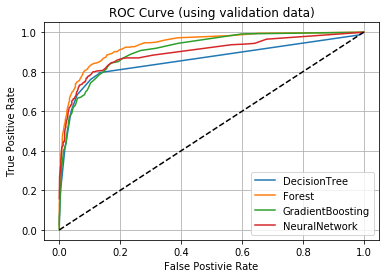

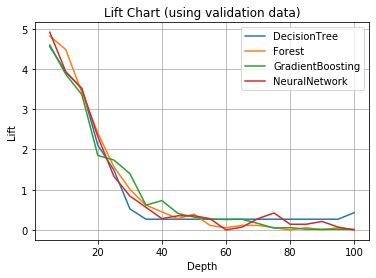

In [15]:
#/* Draw ROC charts */ 
plt.figure()
for key, grp in all_rocinfo.groupby(["model"]):
    plt.plot(grp["FPR"], grp["Sensitivity"], label=key)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Postivie Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="best")
plt.title("ROC Curve (using validation data)")
plt.show()

#/* Draw lift charts */
plt.figure()
for key, grp in all_liftinfo.groupby(["model"]):
    plt.plot(grp["Depth"], grp["Lift"], label=key)
plt.xlabel("Depth")
plt.ylabel("Lift")
plt.grid(True)
plt.legend(loc="best")
plt.title("Lift Chart (using validation data)")
plt.show();

## End CAS session

This closes the CAS session freeing resources for others to leverage

In [ ]:
sess.close()